In [123]:
import pandas as pd
import numpy as np
import re
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import json
from nltk.corpus import stopwords

In [127]:
NB_START_EPOCHS = 10  # Number of epochs we usually start to train with
BATCH_SIZE = 30  # Size of the batches used in the mini-batch gradient descent

def deep_model(model, X_train, y_train, X_valid, y_valid):
    '''
    Function to train a multi-class model. The number of epochs and 
    batch_size are set by the constants at the top of the
    notebook. 
    
    Parameters:
        model : model with the chosen architecture
        X_train : training features
        y_train : training target
        X_valid : validation features
        Y_valid : validation target
    Output:
        model training history
    '''
    model.compile(optimizer='rmsprop'
                  , loss='categorical_crossentropy'
                  , metrics=['accuracy'])
    
    history = model.fit(X_train
                       , y_train
                       , epochs=NB_START_EPOCHS
                       , batch_size=BATCH_SIZE
                       , validation_data=(X_valid, y_valid)
                       , verbose=0)
    return history


def eval_metric(history, metric_name):
    '''
    Function to evaluate a trained model on a chosen metric. 
    Training and validation metric are plotted in a
    line chart for each epoch.
    
    Parameters:
        history : model training history
        metric_name : loss or accuracy
    Output:
        line chart with epochs of x-axis and metric on
        y-axis
    '''
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label='Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label='Validation ' + metric_name)
    plt.legend()
    plt.show()

def test_model(model, X_train, y_train, X_test, y_test, epoch_stop):
    '''
    Function to test the model on new data after training it
    on the full training data with the optimal number of epochs.
    
    Parameters:
        model : trained model
        X_train : training features
        y_train : training target
        X_test : test features
        y_test : test target
        epochs : optimal number of epochs
    Output:
        test accuracy and test loss
    '''
    model.fit(X_train
              , y_train
              , epochs=epoch_stop
              , batch_size=BATCH_SIZE
              , verbose=0)
    results = model.evaluate(X_test, y_test)
    
    return results

def remove_stopwords(input_text):
    '''
    Function to remove English stopwords from a Pandas Series.
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    stop_words = set(stopwords.words('english'))
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stop_words or word in whitelist) and len(word) > 1] 
    return " ".join(clean_words) 
    
def remove_mentions(input_text):
    '''
    Function to remove mentions, preceded by @, in a Pandas Series
    
    Parameters:
        input_text : text to clean
    Output:
        cleaned Pandas Series 
    '''
    return re.sub(r'@\w+', '', input_text)

In [131]:
df = pd.read_csv('../data/english_labels_with_tweets.csv')
print(df)
tweet_texts = df.Text
is_bullying_labels = df['Bullying_Traces?']

                Tweet ID    User ID Bullying_Traces?             Type   Form  \
0     105730486382497793  322329899                y  self-disclosure  other   
1     108654820042354688  361869056                n              NaN    NaN   
2     102206417217392640  226320672                n              NaN    NaN   
3     108676972149874688  157724561                n              NaN    NaN   
4     108901271301394432   91457415                n              NaN    NaN   
...                  ...        ...              ...              ...    ...   
2440  103657243970502656  219840796                y       accusation  other   
2441  106472769763549184  349198033                n              NaN    NaN   
2442  107544553745170432   14302884                n              NaN    NaN   
2443  106313706681532416  143710266                n              NaN    NaN   
2444  107694271313874944  218576888                n              NaN    NaN   

     Teasing? Author_Role Emotion  \
0 

In [183]:
bullying_count_dict = {'y':0, 'n':0}
for bully in is_bullying_labels:
    bullying_count_dict[bully] +=1
print(bullying_count_dict)

{'y': 657, 'n': 1788}


In [187]:
is_teasing_labels = df['Teasing?']
teasing_count_dict = {'y':0, 'n':0}
for tease in is_teasing_labels:
    if tease in teasing_count_dict:
        teasing_count_dict[tease] +=1
    else:
         teasing_count_dict[tease] = 1
print(teasing_count_dict)

{'y': 88, 'n': 569, nan: 1788}


In [175]:
tweet_emotions = df.Emotion
emotion_count_dict = {}
for emotion in tweet_emotions:
    if emotion in emotion_count_dict:
        emotion_count_dict[emotion] +=1
    else:
        emotion_count_dict[emotion] = 1
print(emotion_count_dict)

{'none': 589, nan: 1788, 'anger': 36, 'relief': 1, 'sadness': 21, 'empathy': 7, 'pride': 2, 'other': 1}


In [174]:
tweet_types = df.Type
types_count_dict = {}
for tip in tweet_types:
    if tip in types_count_dict:
        types_count_dict[tip] +=1
    else:
        types_count_dict[tip] = 1
print(types_count_dict)

{'self-disclosure': 309, nan: 1788, 'report': 197, 'denial': 46, 'accusation': 104, 'cyberbullying': 1}


In [177]:
tweet_forms = df.Form
forms_count_dict = {}
for form in tweet_forms:
    if form in forms_count_dict:
        forms_count_dict[form] +=1
    else:
        forms_count_dict[form] = 1
print(forms_count_dict)

{'other': 576, nan: 1788, 'physical': 11, 'cyberbullying': 48, 'property damage': 2, 'verbal': 20}


In [179]:
tweet_roles = df.Author_Role
roles_count_dict = {}
for role in tweet_roles:
    if role in roles_count_dict:
        roles_count_dict[role] +=1
    else:
        roles_count_dict[role] = 1
print(roles_count_dict)

{'victim': 208, nan: 1788, 'reporter': 197, 'bully': 89, 'defender': 58, 'accuser': 104, 'reinforcer': 1}


In [132]:
#ucitavanje tweetova i ciscenje

'''tweet_texts = []
with open("../data/english_tweets.txt", 'r', encoding='utf-8') as f:
    for line in f:
        currentTweet = line[:-1]
        tweet_texts.append(currentTweet)
        
print(len(tweet_texts))
'''
#df = df.reindex(np.random.permutation(df.index))
df.Text = df.Text.apply(remove_stopwords).apply(remove_mentions)
X_train, X_test, y_train, y_test = train_test_split(df.Text, df['Bullying_Traces?'], test_size=0.1, random_state=37)

In [133]:
print('# Train data samples:', X_train.shape[0])
print('# Test data samples:', X_test.shape[0])
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

# Train data samples: 2200
# Test data samples: 245


In [53]:
GLOVE_DIM=100
glove_file = 'C:/Users/erajkovic/Downloads/glove.twitter.27B/glove.twitter.27B.' + str(GLOVE_DIM) + 'd.txt'
emb_dict = {}
NB_WORDS = 4525   # duljina file-a vocab
glove = open(glove_file, encoding="utf8")
print(glove)
for line in glove:
    values = line.split()
    word = values[0]
    vector = np.asarray(values[1:], dtype='float32')
    emb_dict[word] = vector
glove.close()

<_io.TextIOWrapper name='C:/Users/erajkovic/Downloads/glove.twitter.27B/glove.twitter.27B.100d.txt' mode='r' encoding='utf8'>


In [189]:
bullying_words = ["ignored", "pushed", "rumors", "locker", "spread", "shoved", "rumor", "teased", "kicked", 
"crying", "bullied", "bully", "bullyed", "bullying", "bullyer", "bulling"]
for w in bullying_words:
    if w in emb_dict.keys():
        print('Found the word {} in the dictionary'.format(w))
    else:
        print('Didn\'t find word {} in the dictionary'.format(w))

Found the word ignored in the dictionary
Found the word pushed in the dictionary
Found the word rumors in the dictionary
Found the word locker in the dictionary
Found the word spread in the dictionary
Found the word shoved in the dictionary
Found the word rumor in the dictionary
Found the word teased in the dictionary
Found the word kicked in the dictionary
Found the word crying in the dictionary
Found the word bullied in the dictionary
Found the word bully in the dictionary
Didn't find word bullyed in the dictionary
Found the word bullying in the dictionary
Didn't find word bullyer in the dictionary
Found the word bulling in the dictionary


In [135]:
NB_WORDS = 10000 

tk = Tokenizer(num_words=NB_WORDS,
filters='!"#$%&()*+,-./:;<=>?@[\]^_`{"}~\t\n',lower=True, split=" ")
tk.fit_on_texts(X_train)
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

In [136]:
tk.word_index

{'bully': 1,
 'bullying': 2,
 'http': 3,
 'bullied': 4,
 't': 5,
 'co': 6,
 'not': 7,
 'school': 8,
 "i'm": 9,
 'get': 10,
 'like': 11,
 'stop': 12,
 'lol': 13,
 'you': 14,
 'the': 15,
 'people': 16,
 'no': 17,
 'me': 18,
 'it': 19,
 'know': 20,
 'ly': 21,
 'cyber': 22,
 'com': 23,
 'got': 24,
 'one': 25,
 'never': 26,
 'bit': 27,
 'see': 28,
 'back': 29,
 'anti': 30,
 'think': 31,
 'would': 32,
 'getting': 33,
 'big': 34,
 'please': 35,
 'kids': 36,
 'good': 37,
 'love': 38,
 'help': 39,
 'go': 40,
 'im': 41,
 'black': 42,
 'new': 43,
 'twitter': 44,
 'and': 45,
 'this': 46,
 'time': 47,
 'shit': 48,
 'via': 49,
 'video': 50,
 'how': 51,
 'hate': 52,
 'so': 53,
 'really': 54,
 'make': 55,
 'someone': 56,
 'rebecca': 57,
 'want': 58,
 'life': 59,
 'that': 60,
 'say': 61,
 'if': 62,
 'schools': 63,
 'right': 64,
 'bulling': 65,
 'girl': 66,
 'stand': 67,
 'made': 68,
 'need': 69,
 'much': 70,
 'now': 71,
 'haha': 72,
 'let': 73,
 'to': 74,
 'is': 75,
 'little': 76,
 "it's": 77,
 'just':

In [137]:
#matrica s embedinzima incijalizirana na 0
#ako je rijec u pretrained embedinzima, updateamo, inace ostaje vektor s nulama

emb_matrix = np.zeros((NB_WORDS, GLOVE_DIM))

for w, i in tk.word_index.items():
    if i < NB_WORDS:
        vect = emb_dict.get(w)
        if vect is not None:
            emb_matrix[i] = vect
    else:
        break

In [138]:
# pogledaj statistike broja riječi po tweetoima i paddaj do max len
seq_lengths = X_train.apply(lambda x: len(x.split(' ')))
seq_lengths.describe()
MAX_LEN = 32

X_train_seq_trunc = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_seq_trunc = pad_sequences(X_test_seq, maxlen=MAX_LEN)

In [139]:
#pretvori klase u numericki oblik
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

In [140]:
X_train_emb, X_valid_emb, y_train_emb, y_valid_emb = train_test_split(X_train_seq_trunc, y_train_oh, test_size=0.1, random_state=37)

assert X_valid_emb.shape[0] == y_valid_emb.shape[0]
assert X_train_emb.shape[0] == y_train_emb.shape[0]

print('Shape of validation set:',X_valid_emb.shape)

Shape of validation set: (220, 32)


In [141]:
glove_model = models.Sequential()
glove_model.add(layers.Embedding(NB_WORDS, GLOVE_DIM, input_length=MAX_LEN))
glove_model.add(layers.Flatten())
glove_model.add(layers.Dense(2, activation='softmax'))
glove_model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 32, 100)           1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6402      
Total params: 1,006,402
Trainable params: 1,006,402
Non-trainable params: 0
_________________________________________________________________


In [142]:
glove_model.layers[0].set_weights([emb_matrix])
glove_model.layers[0].trainable = False
glove_model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 32, 100)           1000000   
_________________________________________________________________
flatten_7 (Flatten)          (None, 3200)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 2)                 6402      
Total params: 1,006,402
Trainable params: 6,402
Non-trainable params: 1,000,000
_________________________________________________________________


In [143]:
glove_history = deep_model(glove_model, X_train_emb, y_train_emb, X_valid_emb, y_valid_emb)
print(glove_history.history)
print(glove_history.history['accuracy'][-1])

{'val_loss': [0.6246785900809548, 0.6224510344592008, 0.6264037706635215, 0.637176597660238, 0.6494753469120372, 0.6462961272759871, 0.654489435932853, 0.666268225420605, 0.6698070886460218, 0.6770635436881672], 'val_accuracy': [0.7090908885002136, 0.7045454382896423, 0.7136363387107849, 0.7136363387107849, 0.7045454382896423, 0.6909090876579285, 0.6818181872367859, 0.699999988079071, 0.6818181872367859, 0.6909090876579285], 'loss': [0.6282316762389559, 0.5490017546848818, 0.5081339772000457, 0.4763773756496834, 0.4508080523122441, 0.4318638561349927, 0.4145258448340676, 0.3992002100655527, 0.3857451711188663, 0.37221893668174744], 'accuracy': [0.7040404, 0.7383838, 0.7681818, 0.7858586, 0.8055556, 0.8111111, 0.8247475, 0.8368687, 0.8479798, 0.8489899]}
0.8489899


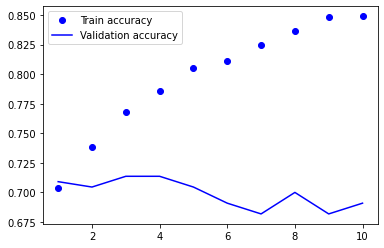

In [144]:
eval_metric(glove_history, 'accuracy')

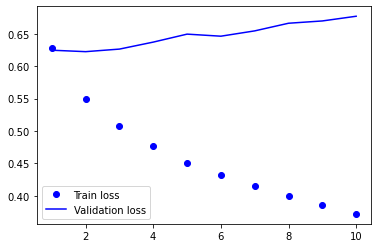

In [145]:
eval_metric(glove_history, 'loss')

In [159]:
glove_results = test_model(glove_model, X_train_seq_trunc, y_train_oh, X_test_seq_trunc, y_test_oh, 3)
print()
print(glove_results)
print('Test accuracy of word glove model: {0:.2f}%'.format(glove_results[1]*100))

245/245 [==============================] - 0s 33us/step

[0.8474974106769173, 0.6530612111091614]
Test accuracy of word glove model: 65.31%


In [162]:
count_n = 0
count_y = 0
for y in y_test:
    if y=='n':
        count_n+=1
    else:
        count_y+=1
print(count_n)
print(count_y)
print(count_n/len(y_test))

182
63
0.7428571428571429


In [193]:
predicted = glove_model.predict(X_test_seq_trunc)
predicted

array([[1.33236349e-01, 8.66763651e-01],
       [8.76375914e-01, 1.23624086e-01],
       [6.92061186e-01, 3.07938844e-01],
       [9.39267993e-01, 6.07320443e-02],
       [5.54151356e-01, 4.45848614e-01],
       [3.42664331e-01, 6.57335639e-01],
       [6.56829774e-01, 3.43170255e-01],
       [7.72681594e-01, 2.27318361e-01],
       [4.74350601e-01, 5.25649428e-01],
       [9.29402769e-01, 7.05972239e-02],
       [7.67534435e-01, 2.32465521e-01],
       [5.72744727e-01, 4.27255243e-01],
       [9.26060081e-01, 7.39398748e-02],
       [9.47306156e-01, 5.26939072e-02],
       [5.03206551e-01, 4.96793509e-01],
       [9.30032670e-01, 6.99673891e-02],
       [5.30403256e-01, 4.69596714e-01],
       [9.28001046e-01, 7.19989240e-02],
       [9.89961624e-01, 1.00383898e-02],
       [9.76591766e-01, 2.34082341e-02],
       [5.29658377e-01, 4.70341593e-01],
       [5.69871426e-01, 4.30128604e-01],
       [9.56972420e-01, 4.30275686e-02],
       [3.81875575e-01, 6.18124425e-01],
       [5.463516